##### Import libraries

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [56]:
data_directory = 'data/'

##### Define class objects and functions

In [57]:
# Custom MultiColumnLabelEncoder class
class MultiColumnLabelEncoder:
    def __init__(self, columns=None):
        self.columns = columns
        self.encoders = {}

    def fit(self, X, y=None):
        columns = X.columns if self.columns is None else self.columns
        for col in columns:
            self.encoders[col] = LabelEncoder().fit(X[col])
        return self

    def transform(self, X):
        output = X.copy()
        columns = X.columns if self.columns is None else self.columns
        for col in columns:
            output[col] = self.encoders[col].transform(X[col])
        return output

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

    def inverse_transform(self, X):
        output = X.copy()
        columns = X.columns if self.columns is None else self.columns
        for col in columns:
            output[col] = self.encoders[col].inverse_transform(X[col])
        return output


def get_data_rows(filename):
    with open(filename, 'r') as file:
        content = file.read()

    rows = content.split('\n')
    data_rows = [row.split(',') for row in rows]
    return data_rows


def column_dtype_changer(df, dtype_old, dtype_new):
    old_dtype_columns = df.select_dtypes(dtype_old).columns
    for col in old_dtype_columns:
        df = df.astype({col: dtype_new})

    return df


def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (data < lower_bound) | (data > upper_bound)


def plot_outliers(df):
    scaler = StandardScaler()
    scaler.fit(df)
    scaled_data = scaler.transform(df)

    pca = PCA(n_components=2)
    pca.fit(scaled_data)
    x_pca = pca.transform(scaled_data)

    plt.figure(figsize=(8, 6))
    plt.scatter(x_pca[:, 0], x_pca[:, 1], cmap='rainbow')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.show()

##### Get data columns

In [58]:
data_columns = [row[0].split(':')[0] for row in get_data_rows(data_directory+'adult.names')[-15:-1]] + ['>50K, <=50K']
data_columns

['age',
 'workclass',
 'fnlwgt',
 'education',
 'education-num',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'native-country',
 '>50K, <=50K']

##### Load train data

In [59]:
train_data = pd.DataFrame(get_data_rows(data_directory+'adult.data')[:-2], columns=data_columns)
train_data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,">50K, <=50K"
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


##### Load test data

In [60]:
test_data = pd.DataFrame(get_data_rows(data_directory+'adult.test')[1:-2], columns=data_columns)
test_data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,">50K, <=50K"
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K.
16277,64,?,321403,HS-grad,9,Widowed,?,Other-relative,Black,Male,0,0,40,United-States,<=50K.
16278,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K.
16279,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K.


##### Data exploration

***Train data exploration***

In [61]:
train_data.dtypes

age               object
workclass         object
fnlwgt            object
education         object
education-num     object
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain      object
capital-loss      object
hours-per-week    object
native-country    object
>50K, <=50K       object
dtype: object

In [62]:
train_data.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
>50K, <=50K       0
dtype: int64

In [63]:
train_data.nunique()

age                  73
workclass             9
fnlwgt            21648
education            16
education-num        16
marital-status        7
occupation           15
relationship          6
race                  5
sex                   2
capital-gain        119
capital-loss         92
hours-per-week       94
native-country       42
>50K, <=50K           2
dtype: int64

In [64]:
train_data.describe()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,">50K, <=50K"
count,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,73,9,21648,16,16,7,15,6,5,2,119,92,94,42,2
top,36,Private,164190,HS-grad,9,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,<=50K
freq,898,22696,13,10501,10501,14976,4140,13193,27816,21790,29849,31042,15217,29170,24720


In [65]:
train_data = train_data.drop('education', axis=1)
train_data

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,">50K, <=50K"
0,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


***Test data exploration***

In [66]:
test_data.dtypes

age               object
workclass         object
fnlwgt            object
education         object
education-num     object
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain      object
capital-loss      object
hours-per-week    object
native-country    object
>50K, <=50K       object
dtype: object

In [67]:
test_data.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
>50K, <=50K       0
dtype: int64

In [68]:
test_data.nunique()

age                  73
workclass             9
fnlwgt            12787
education            16
education-num        16
marital-status        7
occupation           15
relationship          6
race                  5
sex                   2
capital-gain        113
capital-loss         82
hours-per-week       89
native-country       41
>50K, <=50K           2
dtype: int64

In [69]:
test_data.describe()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,">50K, <=50K"
count,16281,16281,16281,16281,16281,16281,16281,16281,16281,16281,16281,16281,16281,16281,16281
unique,73,9,12787,16,16,7,15,6,5,2,113,82,89,41,2
top,35,Private,136986,HS-grad,9,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,<=50K.
freq,461,11210,9,5283,5283,7403,2032,6523,13946,10860,14958,15518,7586,14662,12435


In [70]:
test_data = test_data.drop('education', axis=1)
test_data

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,">50K, <=50K"
0,25,Private,226802,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,39,Private,215419,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K.
16277,64,?,321403,9,Widowed,?,Other-relative,Black,Male,0,0,40,United-States,<=50K.
16278,38,Private,374983,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K.
16279,44,Private,83891,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K.


##### Label encoding the columns

In [71]:
encoding_columns = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', '>50K, <=50K']
multicolumn_encorder = MultiColumnLabelEncoder(columns=encoding_columns)

train_data = multicolumn_encorder.fit_transform(train_data)
train_data = column_dtype_changer(train_data, 'object', 'int64')
train_data

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,">50K, <=50K"
0,39,7,77516,13,4,1,1,4,1,2174,0,40,39,0
1,50,6,83311,13,2,4,0,4,1,0,0,13,39,0
2,38,4,215646,9,0,6,1,4,1,0,0,40,39,0
3,53,4,234721,7,2,6,0,2,1,0,0,40,39,0
4,28,4,338409,13,2,10,5,2,0,0,0,40,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,4,257302,12,2,13,5,4,0,0,0,38,39,0
32557,40,4,154374,9,2,7,0,4,1,0,0,40,39,1
32558,58,4,151910,9,6,1,4,4,0,0,0,40,39,0
32559,22,4,201490,9,4,1,3,4,1,0,0,20,39,0


In [72]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             32561 non-null  int64
 1   workclass       32561 non-null  int64
 2   fnlwgt          32561 non-null  int64
 3   education-num   32561 non-null  int64
 4   marital-status  32561 non-null  int64
 5   occupation      32561 non-null  int64
 6   relationship    32561 non-null  int64
 7   race            32561 non-null  int64
 8   sex             32561 non-null  int64
 9   capital-gain    32561 non-null  int64
 10  capital-loss    32561 non-null  int64
 11  hours-per-week  32561 non-null  int64
 12  native-country  32561 non-null  int64
 13  >50K, <=50K     32561 non-null  int64
dtypes: int64(14)
memory usage: 3.5 MB


In [73]:
test_data = multicolumn_encorder.fit_transform(test_data)
test_data = column_dtype_changer(test_data, 'object', 'int64')
test_data

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,">50K, <=50K"
0,25,4,226802,7,4,7,3,2,1,0,0,40,38,0
1,38,4,89814,9,2,5,0,4,1,0,0,50,38,0
2,28,2,336951,12,2,11,0,4,1,0,0,40,38,1
3,44,4,160323,10,2,7,0,2,1,7688,0,40,38,1
4,18,0,103497,10,4,0,3,4,0,0,0,30,38,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,39,4,215419,13,0,10,1,4,0,0,0,36,38,0
16277,64,0,321403,9,6,0,2,2,1,0,0,40,38,0
16278,38,4,374983,13,2,10,0,4,1,0,0,50,38,0
16279,44,4,83891,13,0,1,3,1,1,5455,0,40,38,0


In [74]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             16281 non-null  int64
 1   workclass       16281 non-null  int64
 2   fnlwgt          16281 non-null  int64
 3   education-num   16281 non-null  int64
 4   marital-status  16281 non-null  int64
 5   occupation      16281 non-null  int64
 6   relationship    16281 non-null  int64
 7   race            16281 non-null  int64
 8   sex             16281 non-null  int64
 9   capital-gain    16281 non-null  int64
 10  capital-loss    16281 non-null  int64
 11  hours-per-week  16281 non-null  int64
 12  native-country  16281 non-null  int64
 13  >50K, <=50K     16281 non-null  int64
dtypes: int64(14)
memory usage: 1.7 MB


##### Get correlation details

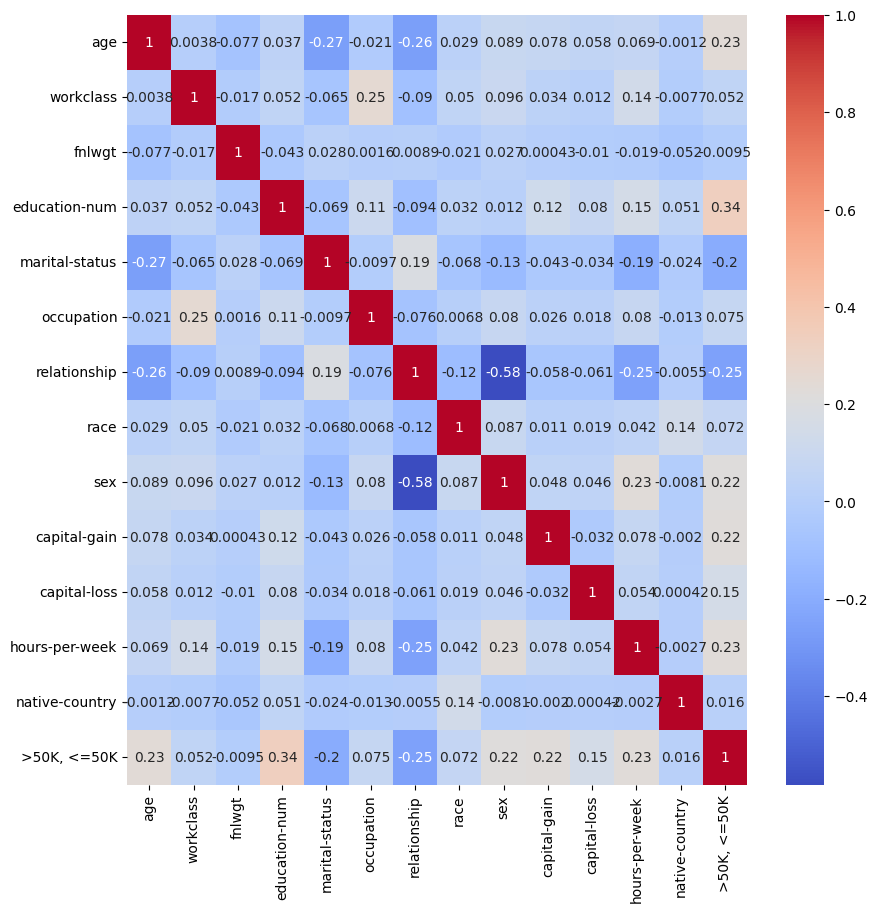

In [75]:
correlation = train_data.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.show()

##### Identify outliers

/tmp/ipykernel_7169/296581394.py:67: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_pca[:, 0], x_pca[:, 1], cmap='rainbow')


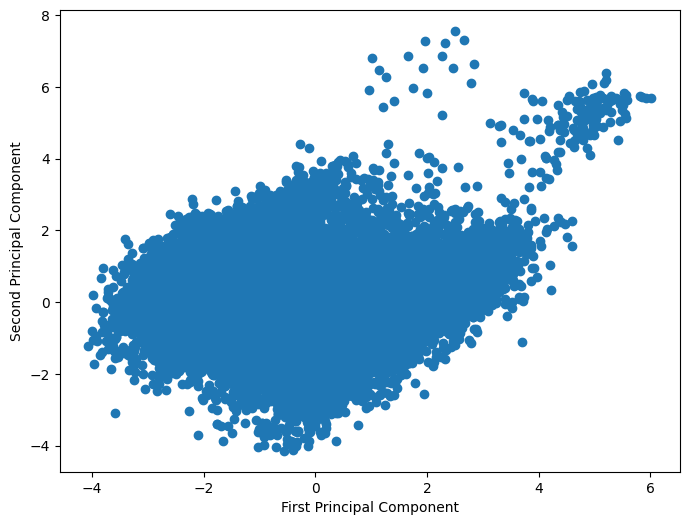

In [76]:
plot_outliers(train_data)

In [77]:
outliers = train_data.apply(detect_outliers_iqr)
outliers

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,">50K, <=50K"
0,False,True,False,False,False,False,False,False,False,True,False,False,False,False
1,False,True,False,False,False,False,False,False,False,False,False,True,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,True,False,False,False,False,False,False
4,False,False,False,False,False,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,False,False,False,False,False,False,False,False,False,False,False,False,False,False
32557,False,False,False,False,False,False,False,False,False,False,False,False,False,True
32558,False,False,False,False,False,False,False,False,False,False,False,False,False,False
32559,False,False,False,False,False,False,False,False,False,False,False,True,False,False


In [78]:
train_data_no_outliers = train_data.mask(outliers, train_data.median(), axis=1)
train_data_no_outliers

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,">50K, <=50K"
0,39,4,77516,13,4,1,1,4,1,0,0,40,39,0
1,50,4,83311,13,2,4,0,4,1,0,0,40,39,0
2,38,4,215646,9,0,6,1,4,1,0,0,40,39,0
3,53,4,234721,7,2,6,0,4,1,0,0,40,39,0
4,28,4,338409,13,2,10,5,4,0,0,0,40,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,4,257302,12,2,13,5,4,0,0,0,38,39,0
32557,40,4,154374,9,2,7,0,4,1,0,0,40,39,0
32558,58,4,151910,9,6,1,4,4,0,0,0,40,39,0
32559,22,4,201490,9,4,1,3,4,1,0,0,40,39,0


/tmp/ipykernel_7169/296581394.py:67: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_pca[:, 0], x_pca[:, 1], cmap='rainbow')


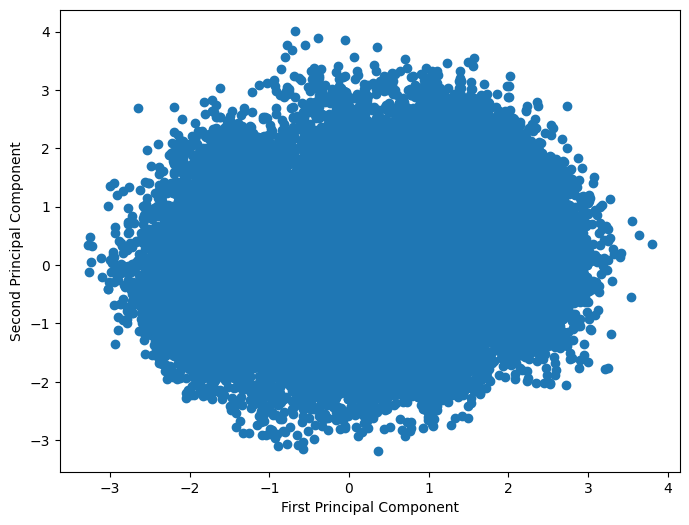

In [79]:
plot_outliers(train_data_no_outliers)